In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
import os
import eli5

In [97]:
pd.set_option(
    'display.float_format',
    lambda x: '%.5f' % x
)

In [140]:
FEATURE_VECTOR = ['query_num_of_columns',
                  'query_num_of_rows',
                  'query_row_column_ratio',
                  #'query_max_mean',
                  'query_max_outlier_percentage',
                  'query_max_skewness',
                  'query_max_kurtosis',
                  'query_max_unique',
                  'candidate_num_of_columns',
                  'candidate_num_rows',
                  'candidate_row_column_ratio',
                  #'candidate_max_mean',
                  'candidate_max_outlier_percentage',
                  'candidate_max_skewness',
                  'candidate_max_kurtosis',
                  'candidate_max_unique',
                  'query_target_max_pearson',
                  'query_target_max_spearman',
                  'query_target_max_covariance',
                  'query_target_max_mutual_info',
                  'candidate_target_max_pearson',
                  'candidate_target_max_spearman',
                  'candidate_target_max_covariance',
                  'candidate_target_max_mutual_info',
                  'max_pearson_difference',
                  'containment_fraction']
ABS_FEATURE_VECTOR = ['query_target_max_pearson',
                      'candidate_target_max_pearson',
                      'query_target_max_spearman',
                      'candidate_target_max_spearman',
                      'query_target_max_covariance',
                      'candidate_target_max_covariance',
                      'query_target_max_mutual_info',
                      'candidate_target_max_mutual_info',
                      'max_pearson_difference']
GAIN_COLUMN_NAME = 'gain_in_r2_score'

In [96]:
def print_df(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        df_sort = df.sort_values('g_r2', ascending=False)
        df_sort.reset_index(inplace=True)
        print(df_sort)

In [66]:
def abs_features(df, features):
    """Applies modulus to the input features.
    """
    
    for f in features:
        df[f] = np.fabs(df[f])

In [145]:
def create_model(alpha, training_filename, feature_vector, gain_column):
    """This functions builds a classifier based on the training data.
    """
    
    training_data = pd.read_csv(training_filename)
    training_data['class'] = ['gain' if row[gain_column] > alpha else 'loss'
                              for index, row in training_data.iterrows()]
    X_train = training_data[feature_vector]
    y_train = training_data['class']
    
    abs_features(X_train, ABS_FEATURE_VECTOR)
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    return clf

In [108]:
def predict_class_for_features(classifier, test_filename, feature_vector):

    test_data = pd.read_csv(test_filename)
    # avoiding overflow
    for col in test_data.select_dtypes([np.number]).columns:
        test_data = test_data[test_data[col] < np.finfo(np.float32).max]
    test_data.reset_index(inplace=True)
    X_test = test_data[feature_vector]
    # replacing NaN values
    if X_test.isna().values.any():
        X_test.fillna(value=0, inplace=True)
        
    abs_features(X_test, ABS_FEATURE_VECTOR)
        
    predicted_classes = classifier.predict(X_test)
    predicted_proba = classifier.predict_proba(X_test)
    
    explanations = list()
    for index, row in X_test.iterrows():
        explanations.append(eli5.explain_prediction_df(classifier, X_test.iloc[index]))
    
    test_data['class'] = predicted_classes
    test_data['candidate'] = test_data['candidate'].apply(
        lambda x: os.path.basename(x)
    )
    test_data.rename(columns={'containment_fraction': 'cf'}, inplace=True)
    test_data.rename(columns={'gain_in_r2_score': 'g_r2'}, inplace=True)
    
    probabilities = pd.DataFrame(predicted_proba, columns=list(classifier.classes_))
    test_data['p(gain)'] = probabilities['gain']
    test_data['p(loss)'] = probabilities['loss']
    
    return (test_data[['candidate', 'cf', 'g_r2', 'class', 'p(gain)', 'p(loss)']], explanations)

In [49]:
def compute_precision_recall(df):
    
    df_sort = df.sort_values('g_r2', ascending=False)
    df_sort.reset_index(inplace=True)
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    tp_vals = list()
    fp_vals = list()
    tn_vals = list()
    fn_vals = list()
    
    for index, row in df_sort.iterrows():
        if row['g_r2'] > 0 and row['class'] == 'gain':
            tp_vals.append((index, row['index'], row['g_r2'], row['p(gain)'], row['cf']))
            tp += 1
        elif row['g_r2'] > 0 and row['class'] == 'loss':
            fn_vals.append((index, row['index'], row['g_r2'], row['p(gain)'], row['cf']))
            fn += 1
        elif row['g_r2'] < 0 and row['class'] == 'gain':
            fp_vals.append((index, row['index'], row['g_r2'], row['p(gain)'], row['cf']))
            fp += 1
        else:
            tn_vals.append((index, row['index'], row['g_r2'], row['p(gain)'], row['cf']))
            tn += 1
            
    print("-- TP:", tp)
    for item in tp_vals:
        print("   . %d\t\t%d\t%.6f\t%.6f\t%.6f"%(item[0], item[1], item[2], item[3], item[4]))
    print("-- TN:", tn)
    for item in tn_vals:
        print("   . %d\t\t%d\t%.6f\t%.6f\t%.6f"%(item[0], item[1], item[2], item[3], item[4]))
    print("-- FP:", fp)
    for item in fp_vals:
        print("   . %d\t\t%d\t%.6f\t%.6f\t%.6f"%(item[0], item[1], item[2], item[3], item[4]))
    print("-- FN:", fn)
    for item in fn_vals:
        print("   . %d\t\t%d\t%.6f\t%.6f\t%.6f"%(item[0], item[1], item[2], item[3], item[4]))

    precision = tp / (tp + fp) if tp + fp > 0 else np.nan
    recall = tp / (tp + fn) if tp + fn > 0 else np.nan
    
    print('Precision: %.4f\nRecall: %.4f'%(precision, recall))

In [7]:
def compute_pearson(df, col_1, col_2):
    return pearsonr(df[col_1], df[col_2])[0]

In [146]:
rf_classifier = create_model(
    alpha=0,
    training_filename='../data/training-for-model.csv',
    feature_vector=FEATURE_VECTOR,
    gain_column=GAIN_COLUMN_NAME
)

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## NY Taxi and Vehicle Collision Problem

In [147]:
taxi_vehicle_collision_classes, taxi_vehicle_collision_explanations = predict_class_for_features(
    rf_classifier,
    'taxi-vehicle-collision-records-features',
    FEATURE_VECTOR
)

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [148]:
print_df(taxi_vehicle_collision_classes)

     index                                          candidate      cf  \
0       49  datamart.socrata.data-cityofnewyork-us.k46n-sa... 0.97238   
1       72  datamart.socrata.data-cityofchicago-org.7ray-x... 0.14365   
2       71  datamart.socrata.data-cityofchicago-org.7ray-x... 0.14365   
3        0  datamart.socrata.data-cityofchicago-org.ijdy-a... 0.14365   
4        1  datamart.socrata.data-cityofchicago-org.ijdy-a... 0.14365   
5       98  datamart.upload.e77dcf0a389444c59f19ea4a0aa5ad... 1.00000   
6       35  datamart.socrata.data-cityofchicago-org.6iiy-9... 1.00000   
7       16  datamart.socrata.data-cityofchicago-org.z2qz-6... 0.14365   
8       17  datamart.socrata.data-cityofchicago-org.z2qz-6... 0.14365   
9       14   datamart.socrata.data-ny-gov.d6yy-54nr_Draw Date 0.24862   
10     120   datamart.socrata.data-ny-gov.6nbc-h7bj_Draw Date 0.28729   
11       5  datamart.socrata.data-cityofnewyork-us.5c4s-jw... 0.03315   
12      84  datamart.socrata.data-cityofnewyork-us.

In [149]:
compute_precision_recall(taxi_vehicle_collision_classes)

-- TP: 28
   . 0		49	4.437217	0.800000	0.972376
   . 1		72	4.243559	0.600000	0.143646
   . 2		71	4.243559	0.600000	0.143646
   . 3		0	4.029437	0.800000	0.143646
   . 4		1	4.029437	0.800000	0.143646
   . 5		98	2.697906	0.500000	1.000000
   . 6		35	2.426317	0.700000	1.000000
   . 7		16	2.090370	0.700000	0.143646
   . 8		17	2.090370	0.700000	0.143646
   . 9		14	1.898933	0.900000	0.248619
   . 10		120	1.621484	0.700000	0.287293
   . 11		5	1.319678	0.700000	0.033149
   . 12		84	1.310169	0.900000	0.033149
   . 13		19	1.289680	0.500000	0.016575
   . 15		80	1.289680	0.800000	0.005525
   . 16		133	1.289680	0.700000	0.005525
   . 17		131	1.289680	0.500000	0.005525
   . 18		21	1.289680	0.900000	0.005525
   . 19		109	1.289680	0.700000	0.027624
   . 20		22	1.289680	0.900000	0.005525
   . 21		58	1.272934	0.600000	0.033149
   . 22		41	0.958919	0.600000	0.143646
   . 24		123	0.894377	0.500000	0.281768
   . 25		13	0.843505	0.700000	0.005525
   . 27		130	0.843505	0.900000	0.005525
   . 28		4	0.658823	0.

In [98]:
taxi_vehicle_collision_explanations[49]  # TP
#taxi_vehicle_collision_explanations[72]  # TP
#taxi_vehicle_collision_explanations[71]  # TP

,target,feature,weight,value
0,gain,<BIAS>,0.56102,1.00000
1,gain,candidate_max_mean,0.12857,57873.73304
2,gain,candidate_target_max_spearman,0.10195,0.23308
3,gain,query_num_of_columns,0.07759,2.00000
4,gain,candidate_target_max_pearson,0.07046,0.16026
5,gain,max_pearson_difference,0.03033,0.19683
6,gain,query_max_mean,0.02729,472266.51381
7,gain,query_max_skewness,0.02175,1.40835
8,gain,candidate_row_column_ratio,0.00915,191.66667
9,gain,query_max_outlier_percentage,0.00764,0.01657


In [123]:
#taxi_vehicle_collision_explanations[76]  # FP
taxi_vehicle_collision_explanations[103]  # FP

,target,feature,weight,value
0,gain,<BIAS>,0.56102,1.00000
1,gain,query_max_outlier_percentage,0.12864,0.01657
2,gain,candidate_max_outlier_percentage,0.08838,0.03571
3,gain,candidate_target_max_spearman,0.08688,0.00000
4,gain,candidate_row_column_ratio,0.07956,7.89744
5,gain,query_target_max_spearman,0.06463,0.23067
6,gain,candidate_target_max_pearson,0.06037,0.00000
7,gain,candidate_num_rows,0.04863,308.00000
8,gain,query_num_of_columns,0.04603,2.00000
9,gain,query_target_max_pearson,0.02397,0.03657


In [76]:
# Pearson between containment fraction and gain in R2
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'g_r2')

0.30926206685429014

In [77]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'cf', 'p(gain)')

0.057036178367895124

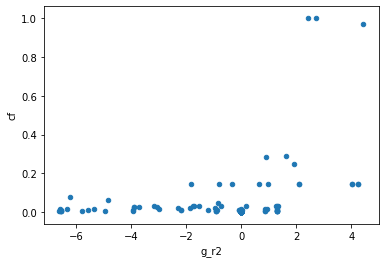

In [86]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='cf', )

In [78]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(taxi_vehicle_collision_classes, 'g_r2', 'p(gain)')

-0.058055263482290224

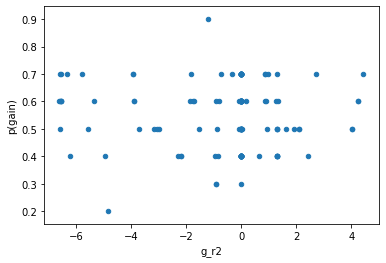

In [87]:
taxi_vehicle_collision_classes.plot.scatter(x='g_r2', y='p(gain)', )

## College Debt

In [15]:
college_debt_classes = predict_class_for_features(
    rf_classifier,
    'college-debt-records-features',
    FEATURE_VECTOR
)

In [16]:
print_df(college_debt_classes)

   index                                          candidate   cf      g_r2  \
0      0      datamart.socrata.data-wa-gov.wajg-ig9g_UNITID  1.0  0.808117   
1      1  datamart.upload.a817349748524c618bec5505f46fea...  1.0  0.727736   

  class  p(gain)  p(loss)  
0  gain      0.8      0.2  
1  gain      0.7      0.3  


In [17]:
compute_precision_recall(college_debt_classes)

-- TP: 2
   . 0		0.808117	0.800000	1.000000
   . 1		0.727736	0.700000	1.000000
-- TN: 0
-- FP: 0
-- FN: 0
Precision: 1.0000
Recall: 1.0000


In [18]:
# Pearson between containment fraction and gain in R2
compute_pearson(college_debt_classes, 'cf', 'g_r2')

/opt/anaconda3/envs/python-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


nan

In [19]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(college_debt_classes, 'cf', 'p(gain)')

nan

In [20]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(college_debt_classes, 'g_r2', 'p(gain)')

1.0

## Poverty Estimation

In [21]:
poverty_estimation_classes = predict_class_for_features(
    rf_classifier,
    'poverty-estimation-records-features',
    FEATURE_VECTOR
)

In [22]:
print_df(poverty_estimation_classes)

   index                                          candidate        cf  \
0      3  datamart.upload.177bdaeafccf45ffb2d28dd1d05719...  1.000000   
1      1     datamart.socrata.data-sfgov-org.49cy-x5m5_MIPS  0.001276   
2      5     datamart.socrata.data-sfgov-org.d7xx-7z6v_MIPS  0.001594   
3      0     datamart.socrata.data-sfgov-org.ua32-eewd_MIPS  0.001276   
4      7     datamart.socrata.data-sfgov-org.858q-nwrm_MIPS  0.000319   
5      8     datamart.socrata.data-sfgov-org.7qzr-p6xn_MIPS  0.001276   
6      6     datamart.socrata.data-sfgov-org.g5sr-9nhs_MIPS  0.000638   
7      4     datamart.socrata.data-sfgov-org.k7mk-w2pq_MIPS  0.001276   
8      2     datamart.socrata.data-sfgov-org.33nh-56zb_MIPS  0.001276   

       g_r2 class  p(gain)  p(loss)  
0  0.028248  gain      0.6      0.4  
1 -0.290706  loss      0.4      0.6  
2 -0.299034  loss      0.3      0.7  
3 -0.299140  loss      0.3      0.7  
4 -0.299818  loss      0.2      0.8  
5 -0.301699  loss      0.3      0.7  
6 -

In [23]:
compute_precision_recall(poverty_estimation_classes)

-- TP: 1
   . 0		0.028248	0.600000	1.000000
-- TN: 7
   . 1		-0.290706	0.400000	0.001276
   . 2		-0.299034	0.300000	0.001594
   . 3		-0.299140	0.300000	0.001276
   . 4		-0.299818	0.200000	0.000319
   . 5		-0.301699	0.300000	0.001276
   . 6		-0.304692	0.300000	0.000638
   . 7		-0.310184	0.300000	0.001276
-- FP: 1
   . 8		-0.317801	0.600000	0.001276
-- FN: 0
Precision: 0.5000
Recall: 1.0000


In [24]:
# Pearson between containment fraction and gain in R2
compute_pearson(poverty_estimation_classes, 'cf', 'g_r2')

0.997610183234824

In [25]:
# Pearson between containment fraction and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'cf', 'p(gain)')

0.6190989311094166

In [26]:
# Pearson between gain in R2 and probability of being classified as gain
compute_pearson(poverty_estimation_classes, 'g_r2', 'p(gain)')

0.5887713733160523